![MLU Logo](https://drive.corp.amazon.com/view/bwernes@/MLU_Logo.png?download=true)

## NLP2 Lecture 1 Support Notebook - part 2

## Question Answering with a fine-tuned BERT on CoQA dataset

### Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install transformers

import torch
from transformers import BertForQuestionAnswering
from transformers import BertTokenizer

### Data loading

In [2]:
coqa = pd.read_json('http://downloads.cs.stanford.edu/nlp/data/coqa/coqa-train-v1.0.json')
coqa.head()

,version,data
0,1,"{'source': 'wikipedia', 'id': '3zotghdk5ibi9ce..."
1,1,"{'source': 'cnn', 'id': '3wj1oxy92agboo5nlq4r7..."
2,1,"{'source': 'gutenberg', 'id': '3bdcf01ogxu7zdn..."
3,1,"{'source': 'cnn', 'id': '3ewijtffvo7wwchw6rtya..."
4,1,"{'source': 'gutenberg', 'id': '3urfvvm165iantk..."


### Data cleaning

In [3]:
del coqa["version"]

In [4]:
coqa.head(6)

,data
0,"{'source': 'wikipedia', 'id': '3zotghdk5ibi9ce..."
1,"{'source': 'cnn', 'id': '3wj1oxy92agboo5nlq4r7..."
2,"{'source': 'gutenberg', 'id': '3bdcf01ogxu7zdn..."
3,"{'source': 'cnn', 'id': '3ewijtffvo7wwchw6rtya..."
4,"{'source': 'gutenberg', 'id': '3urfvvm165iantk..."
5,"{'source': 'race', 'id': '3ftf2t8wlri896r0rn6x..."


In [5]:
cols = ["text","question","answer"]

# j = 1
comp_list = []
for index, row in coqa.iterrows():
    for i in range(len(row["data"]["questions"])):
        temp_list = []
#         temp_list.append(j)
        temp_list.append(row["data"]["story"])
        temp_list.append(row["data"]["questions"][i]["input_text"])
        temp_list.append(row["data"]["answers"][i]["input_text"])
        comp_list.append(temp_list)
#     j += 1
new_df = pd.DataFrame(comp_list, columns=cols) 

In [6]:
new_df.head()

,text,question,answer
0,"The Vatican Apostolic Library (), more commonl...",When was the Vat formally opened?,It was formally established in 1475
1,"The Vatican Apostolic Library (), more commonl...",what is the library for?,research
2,"The Vatican Apostolic Library (), more commonl...",for what subjects?,"history, and law"
3,"The Vatican Apostolic Library (), more commonl...",and?,"philosophy, science and theology"
4,"The Vatican Apostolic Library (), more commonl...",what was started in 2014?,a project


### Saving the data as csv

In [7]:
new_df.to_csv("CoQA_data.csv", index=False)

### Loading the data

In [8]:
data = pd.read_csv("CoQA_data.csv")
data.head()

,text,question,answer
0,"The Vatican Apostolic Library (), more commonl...",When was the Vat formally opened?,It was formally established in 1475
1,"The Vatican Apostolic Library (), more commonl...",what is the library for?,research
2,"The Vatican Apostolic Library (), more commonl...",for what subjects?,"history, and law"
3,"The Vatican Apostolic Library (), more commonl...",and?,"philosophy, science and theology"
4,"The Vatican Apostolic Library (), more commonl...",what was started in 2014?,a project


In [9]:
print("Number of question and answers: ", len(data))

Number of question and answers:  108647


### Building the chatbot

In [10]:
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

In [11]:
random_num = np.random.randint(0,len(data))

question = data["question"][random_num]
text = data["text"][random_num]

In [12]:
print(question, "\n", text)

what else did it get at that time? 
 Denmark, officially the Kingdom of Denmark, is a Nordic country and a sovereign state. The southernmost of the Scandinavian nations, it is south-west of Sweden and south of Norway, and bordered to the south by Germany. The Kingdom of Denmark also comprises two autonomous constituent countries in the North Atlantic Ocean: the Faroe Islands and Greenland. Denmark proper consists of a peninsula, Jutland, and an archipelago of 443 named islands, with the largest being Zealand, Funen and the North Jutlandic Island. The islands are characterised by flat, arable land and sandy coasts, low elevation and a temperate climate. Denmark has an area of , total area including Greenland and the Faroe Islands is , and a population of 5.75 million (). 

The unified kingdom of Denmark emerged in the 10th century as a proficient seafaring nation in the struggle for control of the Baltic Sea. Denmark, Sweden and Norway were ruled together under the Kalmar Union, establi

In [13]:
input_ids = tokenizer.encode(question, text)
print("The input has a total of {} tokens.".format(len(input_ids)))

The input has a total of 378 tokens.


In [16]:
# For each token and its id...
tokens = tokenizer.convert_ids_to_tokens(input_ids)


for token, id in zip(tokens, input_ids):
    print('{:8}{:8,}'.format(token,id))

[CLS]        101
what       2,054
else       2,842
did        2,106
it         2,009
get        2,131
at         2,012
that       2,008
time       2,051
?          1,029
[SEP]        102
denmark    5,842
,          1,010
officially   3,985
the        1,996
kingdom    2,983
of         1,997
denmark    5,842
,          1,010
is         2,003
a          1,037
nordic    13,649
country    2,406
and        1,998
a          1,037
sovereign  11,074
state      2,110
.          1,012
the        1,996
southernmost  21,787
of         1,997
the        1,996
scandinavian  17,660
nations    3,741
,          1,010
it         2,009
is         2,003
south      2,148
-          1,011
west       2,225
of         1,997
sweden     4,701
and        1,998
south      2,148
of         1,997
norway     5,120
,          1,010
and        1,998
bordered  11,356
to         2,000
the        1,996
south      2,148
by         2,011
germany    2,762
.          1,012
the        1,996
kingdom    2,983
of         1,997
den

In [17]:
# Search the input_ids for the first instance of the `[SEP]` token.
# first occurence of [SEP] token
sep_idx = input_ids.index(tokenizer.sep_token_id)
print(sep_idx)

#number of tokens in segment A - question
num_seg_a = sep_idx+1
print(num_seg_a)

#number of tokens in segment B - text
num_seg_b = len(input_ids) - num_seg_a
print(num_seg_b)

segment_ids = [0]*num_seg_a + [1]*num_seg_b
print(segment_ids)

assert len(segment_ids) == len(input_ids)

10
11
367
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [35]:
# Run our example through the model.
start_scores, end_scores = model(torch.tensor([input_ids]), # The tokens representing our input text.
                                 token_type_ids=torch.tensor([segment_ids]))
# The segment IDs to differentiate question from answer_text
print(start_scores,end_scores)

start_logits end_logits


In [36]:
#token input_ids to represent the input
#token segment_ids to differentiate our segments - text and question 
output = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([segment_ids]))
#print(output.start_logits, output.end_logits)

In [37]:
#tokens with highest start and end scores
answer_start = torch.argmax(output.start_logits)
answer_end = torch.argmax(output.end_logits)
print(answer_start, answer_end)

tensor(246) tensor(252)


In [21]:
if answer_end >= answer_start:
    answer = " ".join(tokens[answer_start:answer_end+1])
else:
    print("I am unable to find the answer to this question. Can you please ask another question?")
    
print("Text:\n{}".format(text.capitalize()))
print("\nQuestion:\n{}".format(question.capitalize()))
print("\nAnswer:\n{}.".format(answer.capitalize()))

Text:
Denmark, officially the kingdom of denmark, is a nordic country and a sovereign state. the southernmost of the scandinavian nations, it is south-west of sweden and south of norway, and bordered to the south by germany. the kingdom of denmark also comprises two autonomous constituent countries in the north atlantic ocean: the faroe islands and greenland. denmark proper consists of a peninsula, jutland, and an archipelago of 443 named islands, with the largest being zealand, funen and the north jutlandic island. the islands are characterised by flat, arable land and sandy coasts, low elevation and a temperate climate. denmark has an area of , total area including greenland and the faroe islands is , and a population of 5.75 million (). 

the unified kingdom of denmark emerged in the 10th century as a proficient seafaring nation in the struggle for control of the baltic sea. denmark, sweden and norway were ruled together under the kalmar union, established in 1397 and ending with sw

### Visualization of the tokens

In [22]:
start_scores = output.start_logits.detach().numpy().flatten()
end_scores = output.end_logits.detach().numpy().flatten()

token_labels = []
for i, token in enumerate(tokens):
    token_labels.append("{}-{}".format(token,i))

In [23]:
print(len(token_labels))

378


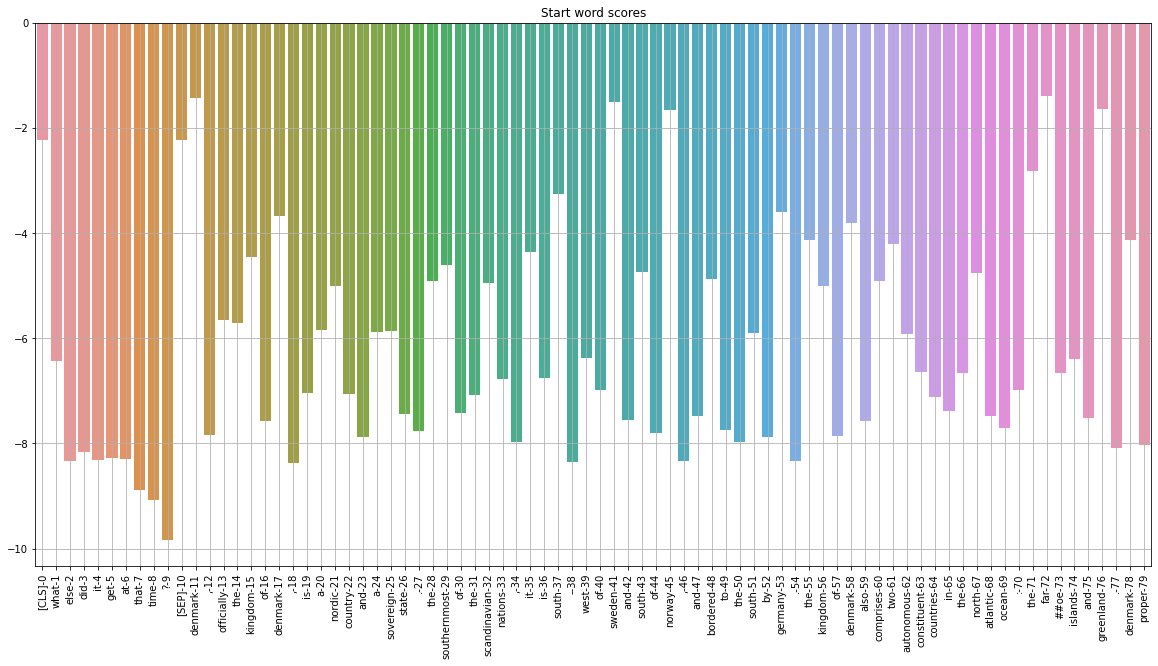

In [24]:
#first 100 tokens
plt.rcParams["figure.figsize"] = (20,10)
ax = sns.barplot(x=token_labels[:80], y=start_scores[:80], ci=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
ax.grid(True)
plt.title("Start word scores")
plt.show()

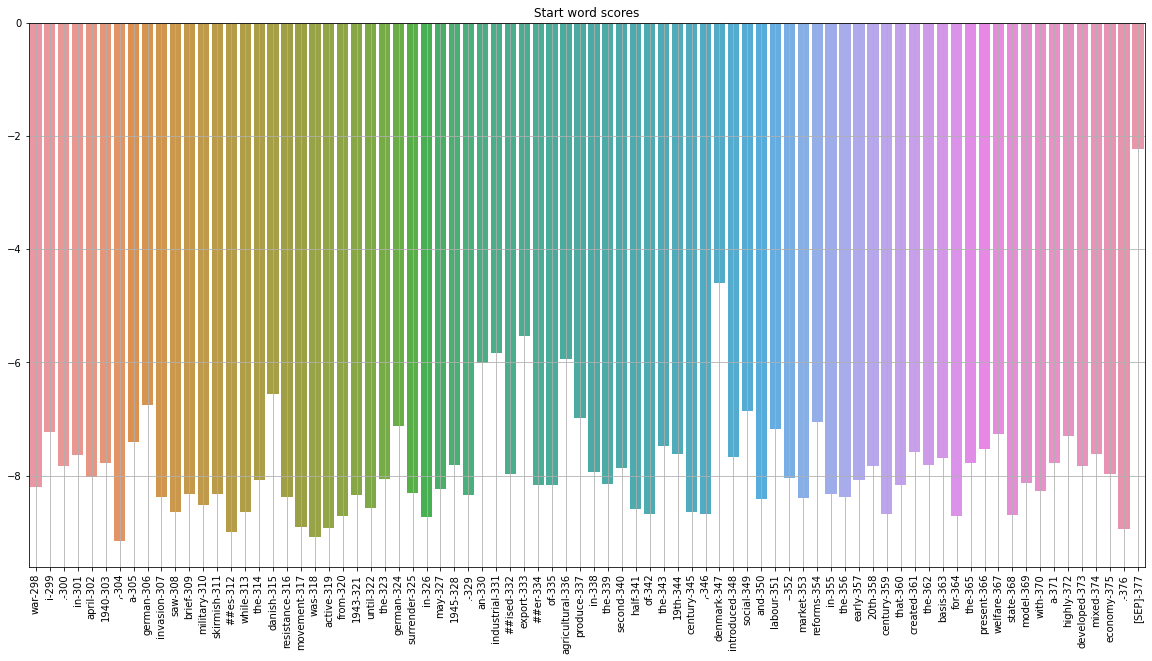

In [25]:
#last 100 tokens
plt.rcParams["figure.figsize"] = (20,10)
ax = sns.barplot(x=token_labels[-80:], y=start_scores[-80:], ci=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
ax.grid(True)
plt.title("Start word scores")
plt.show()

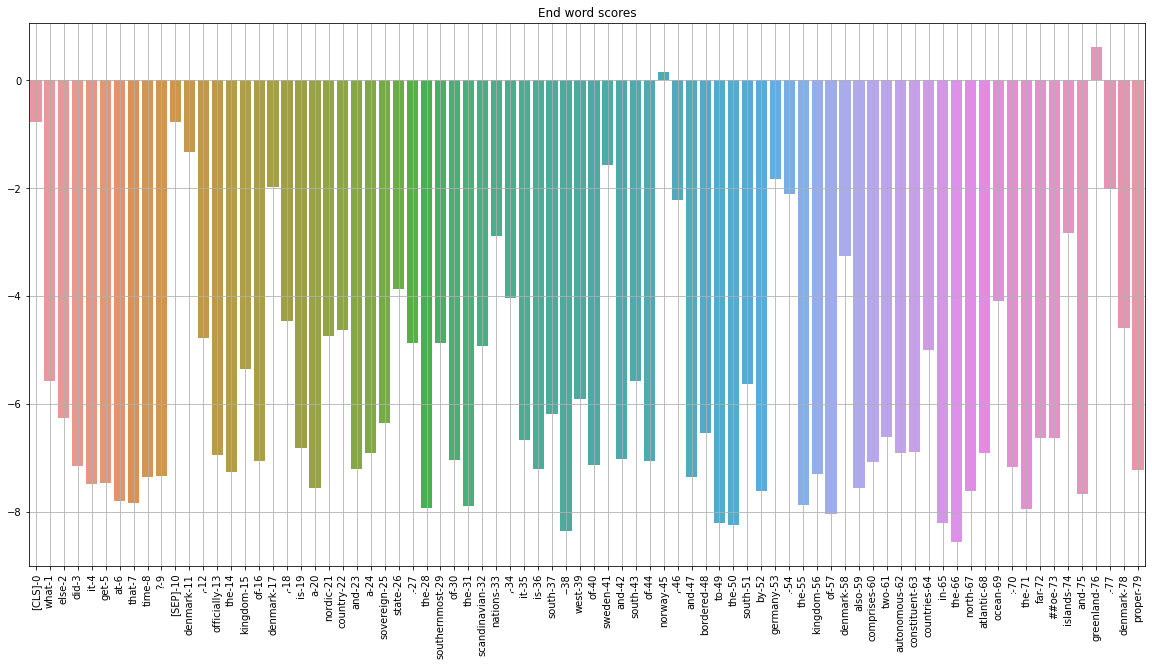

In [26]:
#first 100 tokens
plt.rcParams["figure.figsize"] = (20,10)
ax = sns.barplot(x=token_labels[:80], y=end_scores[:80], ci=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
ax.grid(True)
plt.title("End word scores")
plt.show()

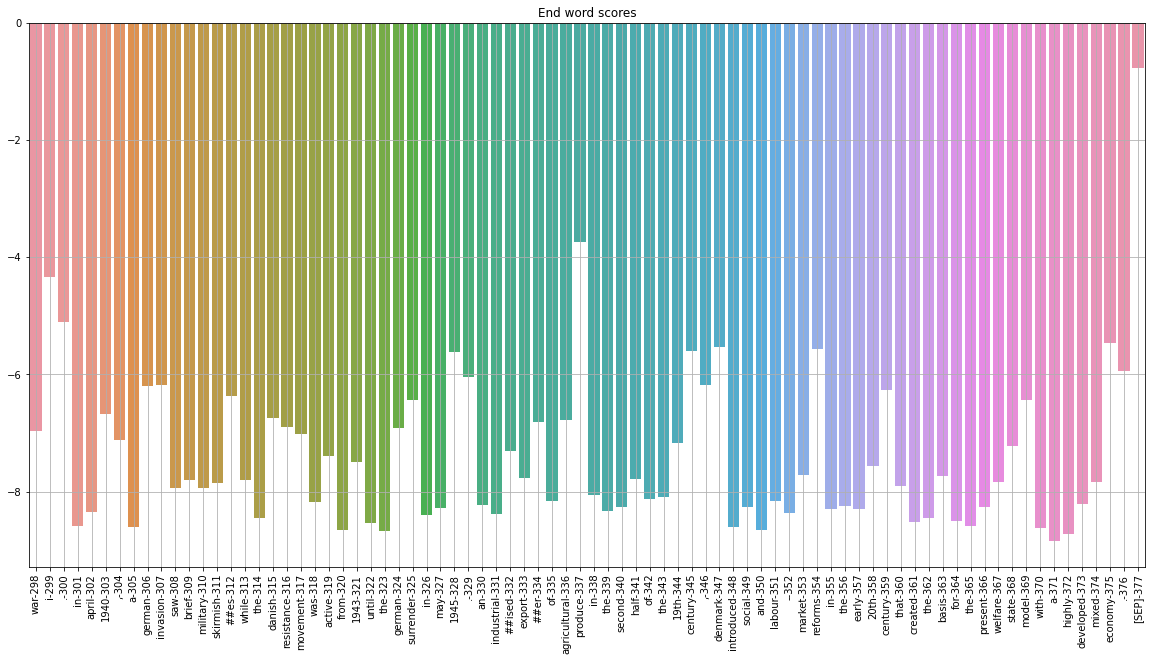

In [27]:
#last 100 tokens
plt.rcParams["figure.figsize"] = (20,10)
ax = sns.barplot(x=token_labels[-80:], y=end_scores[-80:], ci=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
ax.grid(True)
plt.title("End word scores")
plt.show()

### Code to join the broken words

In [28]:
answer = tokens[answer_start]

for i in range(answer_start+1, answer_end+1):
    if tokens[i][0:2] == "##":
        answer += tokens[i][2:]
    else:
        answer += " " + tokens[i]

### Function

In [29]:
def question_answer(question, text):
    
    #tokenize question and text in ids as a pair
    input_ids = tokenizer.encode(question, text)
    
    #string version of tokenized ids
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    
    #segment IDs
    #first occurence of [SEP] token
    sep_idx = input_ids.index(tokenizer.sep_token_id)

    #number of tokens in segment A - question
    num_seg_a = sep_idx+1

    #number of tokens in segment B - text
    num_seg_b = len(input_ids) - num_seg_a
    
    #list of 0s and 1s
    segment_ids = [0]*num_seg_a + [1]*num_seg_b
    
    assert len(segment_ids) == len(input_ids)
    
    #model output using input_ids and segment_ids
    output = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([segment_ids]))
    
    #reconstructing the answer
    answer_start = torch.argmax(output.start_logits)
    answer_end = torch.argmax(output.end_logits)

    if answer_end >= answer_start:
        answer = tokens[answer_start]
        for i in range(answer_start+1, answer_end+1):
            if tokens[i][0:2] == "##":
                answer += tokens[i][2:]
            else:
                answer += " " + tokens[i]
                
    if answer.startswith("[CLS]"):
        answer = "Unable to find the answer to your question."
    
#     print("Text:\n{}".format(text.capitalize()))
#     print("\nQuestion:\n{}".format(question.capitalize()))
    print("\nAnswer:\n{}".format(answer.capitalize()))

In [25]:
text = """New York (CNN) -- More than 80 Michael Jackson collectibles -- including the late pop star's famous rhinestone-studded glove from a 1983 performance -- were auctioned off Saturday, reaping a total $2 million. Profits from the auction at the Hard Rock Cafe in New York's Times Square crushed pre-sale expectations of only $120,000 in sales. The highly prized memorabilia, which included items spanning the many stages of Jackson's career, came from more than 30 fans, associates and family members, who contacted Julien's Auctions to sell their gifts and mementos of the singer. Jackson's flashy glove was the big-ticket item of the night, fetching $420,000 from a buyer in Hong Kong, China. Jackson wore the glove at a 1983 performance during \"Motown 25,\" an NBC special where he debuted his revolutionary moonwalk. Fellow Motown star Walter \"Clyde\" Orange of the Commodores, who also performed in the special 26 years ago, said he asked for Jackson's autograph at the time, but Jackson gave him the glove instead. "The legacy that [Jackson] left behind is bigger than life for me,\" Orange said. \"I hope that through that glove people can see what he was trying to say in his music and what he said in his music.\" Orange said he plans to give a portion of the proceeds to charity. Hoffman Ma, who bought the glove on behalf of Ponte 16 Resort in Macau, paid a 25 percent buyer's premium, which was tacked onto all final sales over $50,000. Winners of items less than $50,000 paid a 20 percent premium."""
question = "Where was the Auction held?"

question_answer(question, text)


Answer:
Hard rock cafe in new york ' s times square


In [26]:
print("Original answer:\n", data.loc[data["question"] == question]["answer"].values[0])

Original answer:
 Hard Rock Cafe


### Playing with the chatbot

In [27]:
text = input("Please enter your text: \n")
question = input("\nPlease enter your question: \n")

while True:
    question_answer(question, text)
    
    flag = True
    flag_N = False
    
    while flag:
        response = input("\nDo you want to ask another question based on this text (Y/N)? ")
        if response[0] == "Y":
            question = input("\nPlease enter your question: \n")
            flag = False
        elif response[0] == "N":
            print("\nBye!")
            flag = False
            flag_N = True
            
    if flag_N == True:
        break

Please enter your text: 
 The Vatican Apostolic Library (), more commonly called the Vatican Library or simply the Vat, is the library of the Holy See, located in Vatican City. Formally established in 1475, although it is much older, it is one of the oldest libraries in the world and contains one of the most significant collections of historical texts. It has 75,000 codices from throughout history, as well as 1.1 million printed books, which include some 8,500 incunabula.   The Vatican Library is a research library for history, law, philosophy, science and theology. The Vatican Library is open to anyone who can document their qualifications and research needs. Photocopies for private study of pages from books published between 1801 and 1990 can be requested in person or by mail.   In March 2014, the Vatican Library began an initial four-year project of digitising its collection of manuscripts, to be made available online.   The Vatican Secret Archives were separated from the library at


Answer:
1475



Do you want to ask another question based on this text (Y/N)?  Y

Please enter your question: 
 what is the library for?



Answer:
Research library for history , law , philosophy , science and theology



Do you want to ask another question based on this text (Y/N)?  Y

Please enter your question: 
 for what subjects?



Answer:
History , law , philosophy , science and theology



Do you want to ask another question based on this text (Y/N)?  N



Bye!


### Version checking

In [28]:
torch.__version__

'1.4.0'